# Analysis of Rain on Snow Database

In [1]:
import sys
sys.path.append('..')

from pathlib import Path

from pqdm.threads import pqdm

import numpy as np
import pandas as pd

# For plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.transforms as transforms

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from ros_database.processing.surface import read_iowa_mesonet_file, load_station_metadata
from ros_database.filepath import SURFOBS_HOURLY_PATH
from ros_database.plotting import plot_event_counts

from ros_database.database_utils import make_observation_counts, make_station_event_counts, heatmap, get_stationid

#from .autonotebook import tqdm as notebook_tqdm

/home/apbarret/mambaforge/envs/rain_on_snow_database/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load common data

In [2]:
# Paths for hourly station files
station_paths = SURFOBS_HOURLY_PATH.glob("*.hourly.csv")

# Station metadata
stations = load_station_metadata()
country_order = stations.sort_values('country').index.values

## Find data with 24 hours of data

In [3]:
observation_count_fp = Path("aross.database.daily_observation_counts.csv")
if not observation_count_fp.exists():
    make_observation_counts(station_paths)

observation_counts = pd.read_csv(observation_count_fp, index_col=0, parse_dates=True)
observation_counts.tail()

,PAFM,PAKP,CYQH,ESNS,BIKF,UOOO,PAYA,UHMP,ENNA,ESPE,...,BGKK,PAGK,USRR,PAIW,UERP,PABR,PAVD,PFSH,CYDA,CYSM
datetime,,,,,,,,,,,,,,,,,,,,,
2023-11-09,24.0,24.0,24.0,24.0,24.0,24.0,24.0,NaN,24.0,24.0,...,24.0,21.0,24.0,24.0,24.0,17.0,24.0,24.0,10.0,23.0
2023-11-10,24.0,24.0,24.0,24.0,24.0,24.0,24.0,NaN,24.0,24.0,...,24.0,22.0,24.0,24.0,24.0,17.0,24.0,24.0,10.0,24.0
2023-11-11,23.0,24.0,24.0,24.0,24.0,24.0,24.0,NaN,24.0,24.0,...,24.0,24.0,24.0,24.0,24.0,17.0,24.0,24.0,10.0,24.0
2023-11-12,24.0,24.0,24.0,24.0,24.0,24.0,24.0,NaN,24.0,24.0,...,24.0,22.0,24.0,24.0,24.0,15.0,24.0,24.0,10.0,24.0
2023-11-13,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN


Find stations with greater than 90% completeness - where completeness is the percentage of days in the 2004 to 2023 period with greater than 20 hours of observations.

Are the any stations with a complete record?

In [15]:
min_daily_obs = 24
completeness = 0.75  # percentage of days in year exceeding min_daily_obs
ybeg = "2004"

# Find if any stations have perfectly complete record
df = observation_counts[ybeg:]
annual_obs = (df >= min_daily_obs).resample("Y").sum()
annual_obs = annual_obs.div(annual_obs.index.dayofyear, axis=0)
full_record = (annual_obs >= completeness)
station_with_full_year = full_record.columns[full_record.any(axis=0)]  # Find stations with at least one full year

# Get years with complete hourly observations
stations_with_full_record = []
for i, station in enumerate(station_with_full_year):
    if full_record[station].all(axis=0):
        stations_with_full_record.append(station)
        print(f"{i:03} {station}: {full_record.index.year[full_record[station]].tolist()}")

004 BIKF: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
010 ESSA: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
031 PAFA: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
037 PAEN: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
044 PAOM: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
047 ENBO: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
054 CYFB: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
079 CYEV: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 

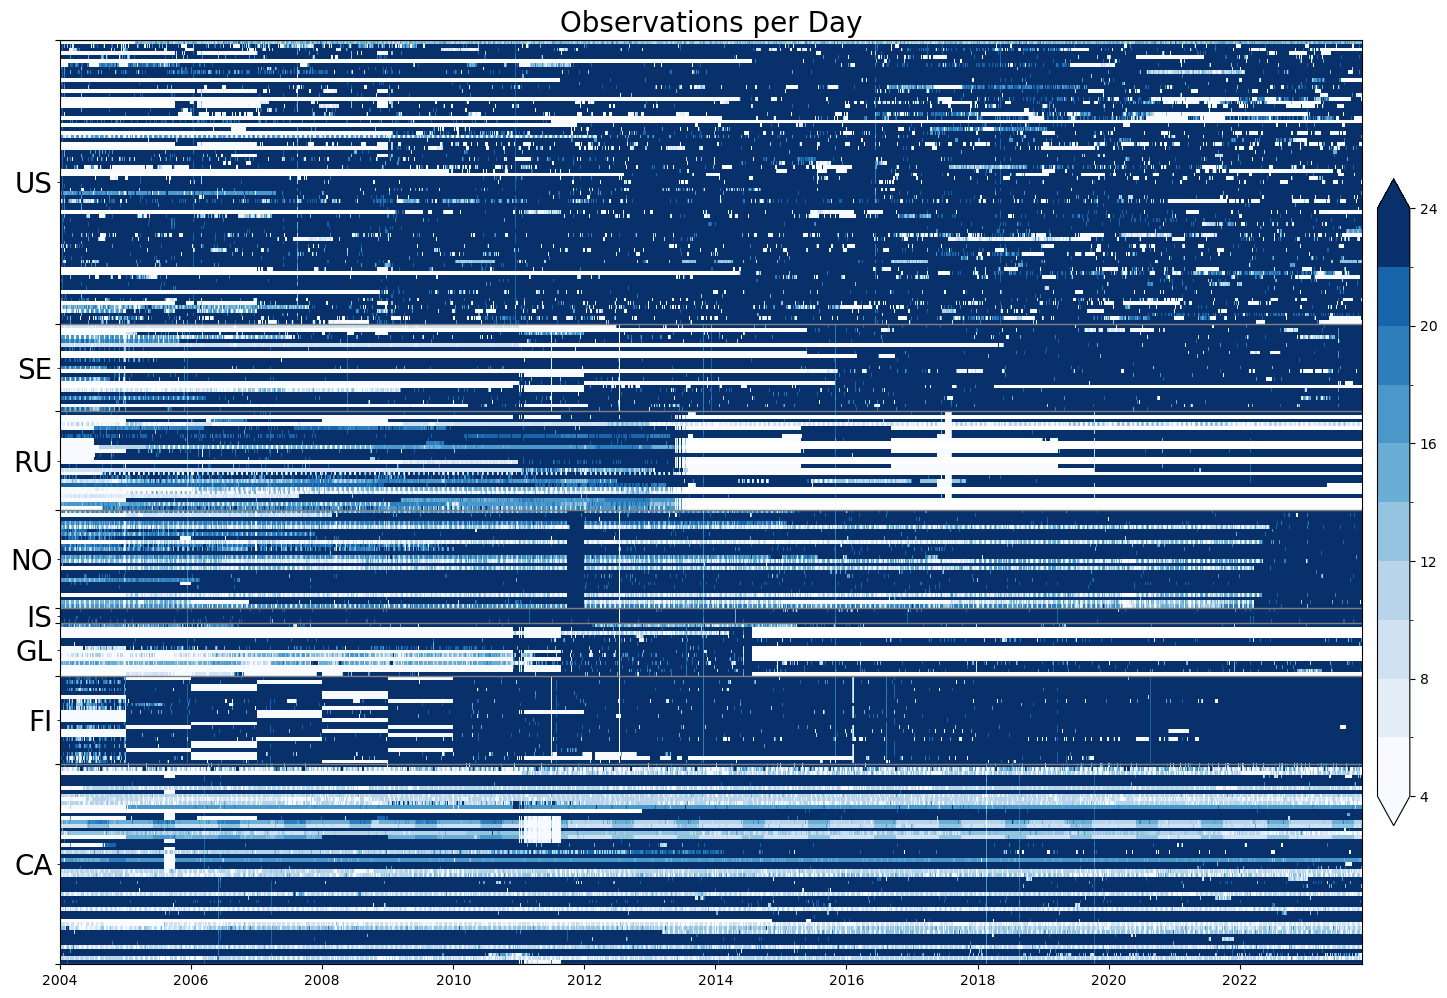

In [5]:
xs = 20
ys = 12
fig, ax = plt.subplots(figsize=(xs, ys))

heatmap(observation_counts.loc[slice("2004","2024"), country_order], fig=fig, ax=ax, 
        levels=[4., 6., 8., 10., 12., 14., 16., 18., 20., 22., 24.], extend="both", cmap='Blues', 
        aspect="auto", base=2)
ax.set_title("Observations per Day", fontsize=20)
fig.savefig("aross.database.observations_per_day.png")

## Plot map of station reporting for POR

In [23]:
lon, lat = list(zip(stations.loc[stations_with_full_record,["longitude","latitude"]].values.T))
lon, lat

((array([ -22.58758,   17.95083, -147.87611, -151.2391 , -165.44525,
           14.36667,  -68.55583, -133.48278, -126.80028, -114.44028,
         -141.92917,   18.54   , -115.14389,  -92.11583,  -68.42694,
          -60.42583, -145.45111, -150.02611, -156.65389]),),
 (array([63.97468, 59.62639, 64.80389, 60.5797 , 64.5122 , 67.26667,
         63.75639, 68.30417, 65.2825 , 62.46278, 62.96139, 69.05889,
         67.81667, 62.81139, 58.09611, 53.31917, 60.48889, 61.16972,
         58.68361]),))

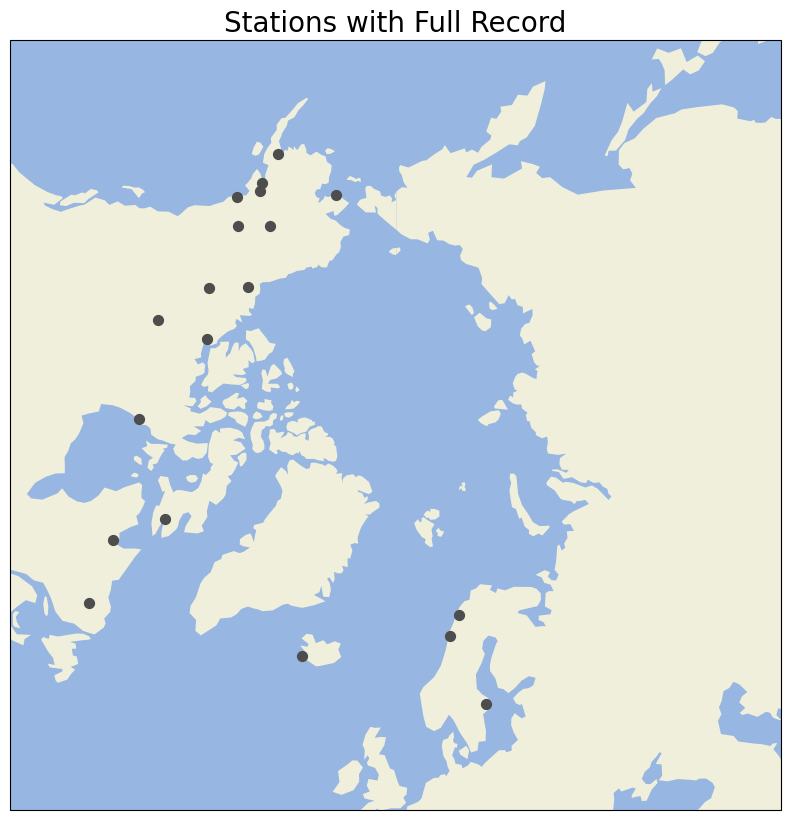

In [27]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180., 180., 50., 90.], ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)

ax.set_title("Stations with Full Record", fontsize=20);

ax.scatter(lon, lat, s=50, color='0.3', transform=ccrs.PlateCarree())

## Explore total event counts

We generate a `pandas.DataFrame` containing total number of events by type for each station

#### Load event counts for stations

In [5]:
station_event_count_fp = Path("station_event_counts_winter.csv")
if not station_event_count_fp.exists():
    make_station_event_counts(season="winter")
total_events = pd.read_csv(station_event_count_fp, index_col=0)
total_events.head()

,UP,RA,FZRA,SOLID,ROS,Total,longitude,latitude
PAFM,606,808,0,11050,808,11858,-157.85747,67.10631
PAKP,291,177,0,13121,177,13298,-151.74334,68.13360
CYQH,0,1307,81,22957,1388,24345,-128.82250,60.11639
ESNS,294,2700,73,12396,2773,15169,21.07694,64.62472
BIKF,0,12639,5,6984,12644,19628,-22.58758,63.97468


In [21]:
total_events.tail()

,UP,RA,FZRA,SOLID,ROS,Total,longitude,latitude
PABR,1233,475,345,87207,820,88027,-156.79224,71.28257
PAVD,1170,6917,10,10229,6927,17156,-146.24800,61.13400
PFSH,1574,1678,0,8857,1678,10535,-161.22397,64.37108
CYDA,0,489,43,10026,532,10558,-139.12778,64.04306
CYSM,0,1434,190,34863,1624,36487,-111.92899,60.02640


## Make map of number of events

array([[<Axes: title={'center': 'UP'}>, <Axes: title={'center': 'RA'}>],
       [<Axes: title={'center': 'FZRA'}>,
        <Axes: title={'center': 'SOLID'}>],
       [<Axes: title={'center': 'ROS'}>, <Axes: >]], dtype=object)

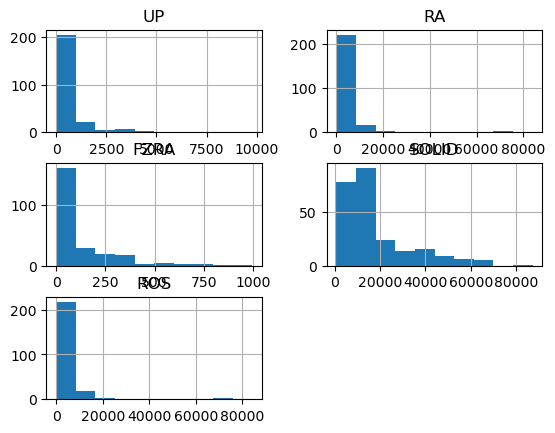

In [6]:
total_events[["UP","RA","FZRA","SOLID","ROS"]].hist()

Figure(1000x1000)


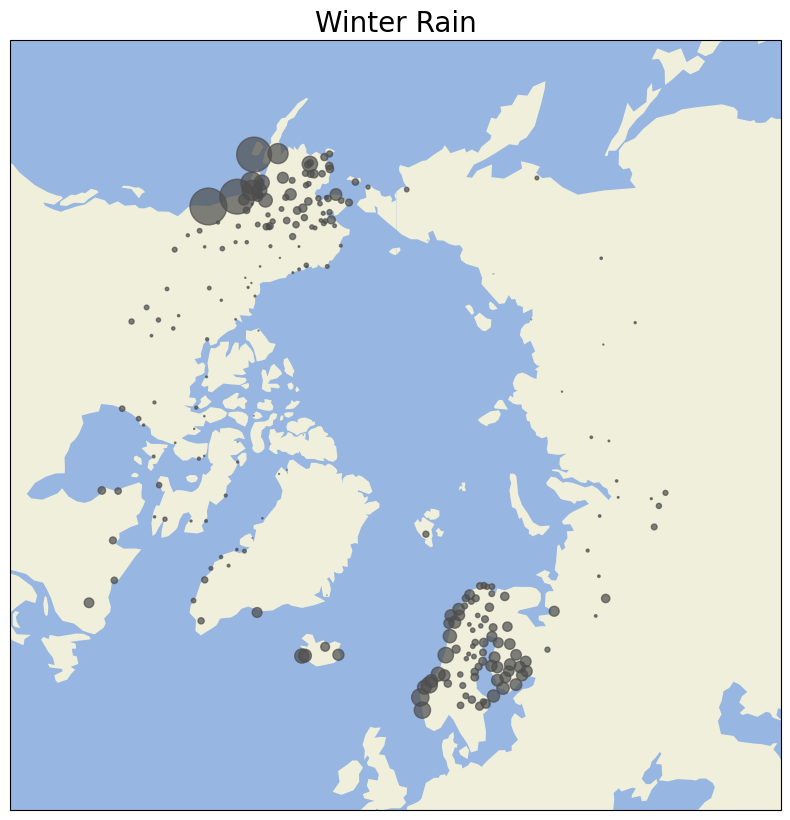

In [7]:
event_type = "ROS"
fig = plt.figure(figsize=(10,10))
ax = plot_event_counts(total_events, event_type=event_type, )
fig.savefig("aross.database.winter_ros_event_map.png")

In [ ]:
event_type = "Total"
fig = plt.figure(figsize=(10,10))
ax = plot_event_counts(total_events, event_type, )
fig.savefig("aross.database.winter_total_event_map.png")

## Make a heat map of events by month

In [ ]:
def month_event_counts(df):
    """Returns a DataFrame containing events aggregated by month"""
    month_df = df[['UP', 'RA', 'FZRA', 'SOLID']].resample('M').sum()
    month_df['ROS'] = month_df['RA'] + month_df['FZRA']
    return month_df

In [ ]:
data = []
indices = []
for fp in SURFOBS_HOURLY_PATH.glob("*.hourly.csv"):
    df = read_iowa_mesonet_file(fp)
    indices.append(get_stationid(df))
    data.append(month_event_counts(df))
df_all = pd.concat(data, axis=1, keys=indices).astype("float")

In [ ]:
df_all.to_csv("aross.database.month_event_counts.csv")

In [ ]:
def get_single_ptype(df, ptype: str):
    """Extracts columns for a single precipitation type"""
    return df.xs(ptype, level=1, axis=1)

In [ ]:
RA = get_single_ptype(df_all, 'RA').replace(to_replace=0, value=np.nan)
FZRA = get_single_ptype(df_all, 'FZRA').replace(to_replace=0, value=np.nan)
SOLID = get_single_ptype(df_all, 'SOLID').replace(to_replace=0, value=np.nan)
ROS = get_single_ptype(df_all, 'ROS').replace(to_replace=0, value=np.nan)

In [ ]:
def make_yticklabels(y, interval=5.):
    """Returns yticks and ylabels"""
    if y.dtype != 'float64':
        raise TypeError(f"Expects float, got {y.dtype}")
    ylabels = np.arange(y.min().round(-1), y.max().round(-1)+interval, interval)
    yticks = np.interp(ylabels, y, np.arange(len(y)))
    return yticks, ylabels

def heatmap(X, y=None, ax=None, aspect=0.4, cmap='viridis', **kwargs):
    """Plots a heat map with date labels
    
    :X: pd.DataFrame containing counts
    :y: alternative y labels, expects np.array
    """
    if ax is None:
        ax = plt.gca()
    
    x = X.index
    if y is None:
        y = X.columns
        yticks = np.arange(len(y))
        ylabels = y
    else:
        raise NotImplementedError("Alternative y-labels are not implemented yet")
        yticks, ylabels = make_yticklabels(y, interval=2.)
    data = X.T.values
    
    yticks = [0, 53,  76,  90,  94, 120, 146, 169, 244]
    ylabels = ['CA', 'FI', 'GL', 'IS', 'NO', 'RU', 'SE', 'US']
    xticks = np.where(X.index.month == 1)[0]
    xlabels = X.index.year[xticks]
    
    cmap = mcolors.ListedColormap(mpl.colormaps[cmap](np.linspace(0.,1.,5)))
    norm = mcolors.BoundaryNorm([1.,50.,100.,150.,200.], ncolors=cmap.N, clip=False)
    im = ax.imshow(data, aspect=aspect, cmap=cmap, **kwargs, origin='upper', norm=norm,
                   interpolation="none")
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, fontsize=15)
    ax.set_yticks(yticks)
    ax.set_yticklabels([])
    ax.set_yticks([(yticks[i]+yticks[i+1])*0.5 for i in range(len(yticks)-1)], minor=True)
    ax.set_yticklabels(ylabels, fontsize=20, minor=True)
    
    ax.grid(axis='y', which='major', linewidth=1, color='0.2')
    
    fig.colorbar(im, shrink=0.7, pad=0.01, extend='max')

In [ ]:
xs = 20
ys = 12
fig, ax = plt.subplots(figsize=(xs, ys))

country_order = stations.sort_values('country').index.values
heatmap(ROS.loc[slice("2000","2024"),country_order], cmap="viridis_r", aspect=ys/xs,)
fig.savefig('ros_timeseries_heatmap.png')

In [ ]:
xs = 20
ys = 12
fig, ax = plt.subplots(figsize=(xs, ys))

country_order = stations.sort_values('country').index.values
heatmap(FZRA.loc[slice("2000","2024"),country_order], cmap="viridis_r", aspect=ys/xs)

In [ ]:
xs = 20
ys = 12
fig, ax = plt.subplots(figsize=(xs, ys))

country_order = stations.sort_values('country').index.values
heatmap(SOLID.loc[slice("2000","2024"),country_order], cmap="viridis_r", aspect=ys/xs)

## Plot monthly distribution of counts

In [ ]:
month_counts = RA.groupby(RA.index.month).sum().replace({0.: np.nan})
month_fraction = month_counts / month_counts.sum()
month_counts

In [ ]:
month_counts.max(axis=1)

In [ ]:
month_counts.sum(axis=1).plot.bar()

In [ ]:
def month_heatmap(X, y=None, ax=None, aspect=0.4, cmap='viridis', **kwargs):
    """Plots a heat map with date labels
    
    :X: pd.DataFrame containing counts
    :y: alternative y labels, expects np.array
    """
    if ax is None:
        ax = plt.gca()
    
    x = X.index
    if y is None:
        y = X.columns
        yticks = np.arange(len(y))
        ylabels = y
    else:
        raise NotImplementedError("Alternative y-labels are not implemented yet")
        yticks, ylabels = make_yticklabels(y, interval=2.)
    data = X.T.values
    
    yticks = [0, 53,  76,  90,  94, 120, 146, 169, 244]
    ylabels = ['CA', 'FI', 'GL', 'IS', 'NO', 'RU', 'SE', 'US']
    xticks = np.arange(12) + 0.5
    xlabels = ['J','F','M','A','M','J','J','A','S','O','N','D']
    
    cmap = mcolors.ListedColormap(mpl.cm.get_cmap(cmap)(np.linspace(0.,1.,)))
    norm = mcolors.BoundaryNorm([1.,1000.,2000.,3000.,4000.], ncolors=cmap.N, clip=False)
    im = ax.imshow(data, aspect=aspect, cmap=cmap, norm=norm, 
                   origin='upper', extent=[0.,12.,0.,244.],
                  interpolation='none', **kwargs)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, fontsize=15)
    ax.set_yticks(yticks)
    ax.set_yticklabels([])
    ax.set_yticks([(yticks[i]+yticks[i+1])*0.5 for i in range(len(yticks)-1)], minor=True)
    ax.set_yticklabels(ylabels, fontsize=20, minor=True)
    
    ax.grid(axis='y', which='major', linewidth=1, color='0.2')
    
    fig.colorbar(im, shrink=0.7, pad=0.01, extend='max')
    

In [ ]:
xs = 12
ys = 12
fig, ax = plt.subplots(figsize=(xs, ys))

country_order = stations.sort_values('country').index.values
month_heatmap(month_counts[country_order], cmap="viridis_r", aspect=0.05)

fig.savefig('month_heatmap_ra.png')

## Look at relationship between RA, FZRA and SOLID, and T2m and D2m

In [ ]:
df_to_concat = []
for fp in SURFOBS_HOURLY_PATH.glob("*.hourly.csv"):
    df = read_iowa_mesonet_file(fp) 
    df_to_concat.append(df[df.RA | df.FZRA | df.SOLID].dropna(subset=['t2m', 'd2m']))
df_all = pd.concat(df_to_concat)
df_all.head()

In [ ]:
len(df_all)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,9))

xlim = ylim = (-60,60)

df_all[df_all.RA].plot.scatter(x='t2m', y='d2m', xlim=xlim, ylim=ylim, ax=ax[0], title='Rain')
ax[0].set_aspect('equal')
ax[0].grid(zorder=3)

df_all[df_all.FZRA].plot.scatter(x='t2m', y='d2m', xlim=xlim, ylim=ylim, ax=ax[1], title='Freezing Rain')
ax[1].set_aspect('equal')
ax[1].grid(zorder=3)

df_all[df_all.SOLID].plot.scatter(x='t2m', y='d2m', xlim=xlim, ylim=ylim, ax=ax[2], title='Solid')
ax[2].set_aspect('equal')
ax[2].grid(zorder=3)


### Look at the monthly plots

In [ ]:
station_paths = list(SURFOBS_HOURLY_PATH.glob("*.hourly.csv"))

In [ ]:
fp = station_paths[20]
df = read_iowa_mesonet_file(fp)

In [ ]:
df.head()

In [ ]:
df

### Read surface cover

In [ ]:
snow_cover = pd.read_csv("ims.surface_values.stations.csv", index_col=0, parse_dates=True)
snow_cover

In [ ]:
station in snow_cover

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,5), sharex=True)



In [ ]:
columns = ["t2m","d2m","RA","FZRA","SOLID"]
nstation = 0
for fp in station_paths:
    df = read_iowa_mesonet_file(fp)
    df = df.loc[slice("2000",)]
    if df[columns].dropna().resample('Y').count().apply(lambda x: (x > 7884).all()).all():
        #print(fp)
        nstation += 1
print(nstation)

In [ ]:
len(station_paths)

In [ ]:
df.t2m.plot()

In [ ]:
import datetime as dt

window = 10  # days
fraction = 8

t2m_mean = df["t2m"].resample('D').mean()
iswinter = t2m_mean.rolling(dt.timedelta(days=window),min_periods=window).apply(lambda x: (x < 0.).sum() >= fraction)  

In [ ]:
year = "2006"

fig, ax = plt.subplots(figsize=(12,8))

t2m_mean.loc[year].plot(ax=ax)
iswinter.loc[year].plot(ax=ax)
ax.axhline(0,c='0.7')



In [ ]:
plt.scatter(t2m_mean.index.day_of_year, t2m_mean, s=1)